# Programming Exercise 3: Multi-Class Classification and Neural Networks

Welcome to programming exercise 3, Multi-Class Classification and Neural Networks! In this exercise, we will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

**Instruction:**
- To run code, click on a corresponding cell and press `Shift+Enter` keys simultaneously or Click `Cell -> Run` Cells.

**Objective:**
- To implement one-vs-all classification algorithm to classify data points belonging to more than two discrete outcomes.

**You will learn how to:**
- implement one-vs-all classification
    - objective/cost function
    - gradient function
    - sigmoid function
    - scipy for optimization

## Import packages ##

First lets run the cell below to import all the packages that you will need for this exercise.
- [NumPy](http://www.numpy.org) is the fundamental package for scientific computing with Python.
- [Matplotlib](http://matplotlib.org) is a common library to plot graphs in python.
- [Scipy](https://docs.scipy.org/doc/scipy-0.17.0/reference/optimize.html) a python library for optimization functions.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Import common libr
import numpy as np
import scipy.io as sio 
from scipy import optimize as opt

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Part 1. - Multi-class Classification##

For this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks.

## 1.1 - Load training data ##

We are given a data set in `./data/ex3data1.mat` that contains 5000 training examples of handwritten digits. The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the load command. After loading, matrices of the correct dimensions and values will appear in your program's memory. The matrix will already be named, so you do not need to assign names to them.

In [2]:
#IMPORTING DATA FILES
df_path = 'data/ex3data1.mat'
data = sio.loadmat(df_path)
X = data['X']
y = data['y']

Use the `np.unique()` to uniquely output discrete values contained in the vector `y`. 

In [3]:
# RESULTS CHECK
print('X has shape: ', X.shape)
print('Y has shape: ', y.shape)
print('Unique elements in Y: %s' %(np.unique(y)))

X has shape:  (5000, 400)
Y has shape:  (5000, 1)
Unique elements in Y: [ 1  2  3  4  5  6  7  8  9 10]


There are 5000 training examples in the provided dataset, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

## 1.2 - Visualizing the data ##

Let us begin by visualizing the subset of the training dataset. We will randomly selects selects 25 rows from `X` and passes those rows to the `displayData()` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

In [4]:
rand_indices = np.random.permutation(X.shape[0]);
sel = X[rand_indices[:25], :]

Next, we define a simple display function that takes as input a randomly selected 25 rows...and displays them digits.

In [5]:
def displayData(sel):
    fig, ax = plt.subplots(nrows =5, ncols=5, sharex=True, sharey=True,)
    ax = ax.flatten()
    for i in range(25):
        img = sel[i].reshape(20,20,order="F")
        ax[i].imshow(img, cmap=matplotlib.cm.binary, interpolation="nearest")
        ax[i].axis('on')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

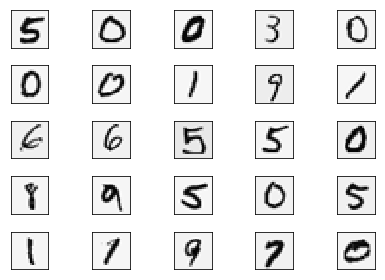

In [6]:
displayData(sel)

## 1.3 - Vectorizing Logistic Regression

In this exercise, we will be using multiple `one-vs-all logistic regression models` to build a `multi-class classifier`. Since there are 10 classes, we will need to train 10 separate logistic regression classifiers. 

We will reuse our logistic regression code from the last exercise to succed in this exercise. 

**1.3.1 - Sigmoid function**

 The sigmoid function  also refered to as `logistic function` or a  `logit` is defined as:
 $${\sigma{(z)}} = \frac{1}{ 1 + {e^{-z}}} \tag{1}$$
 
 where ${z} = {\theta^T{x}}$. 

In [7]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

**1.3.2 - The 'z' in sigmoid function**

The '${z}$' in the sigmoid function in `equation 1` ${z} = {\theta^T{x}}$ has a vectorized form ${z} = {X\theta}$. Next we implement this vectorized form of '${z}$'!

In [8]:
def z(x, theta):
    return np.dot(x,theta)

**1.3.3 - Regularized cost function**

- `Logistic regression (unregularized)`, the cost function is given by:

$${J(\theta)} = -\frac{1}{m}{\sum_{i=1}^m}{\biggl[{y^{(i)}\,log\,{(h_\theta (x^{(i)})})}  + (1-y)^{(i)}\,log\,{(1 - h_\theta (x^ {(i)})})\biggl]}\tag{2}$$

     - Its vectorized form(unregularized) as:

$$J{(\theta)} = \frac{1}{m}{\biggl[{-y^T\,log{(h)} -(1-y)^T\,log{(1 - h)}}\biggl]}$$
 

- For `regularized logistic regression`, the cost function is defined by adding a second term ${\frac{\lambda}{2m}} {\sum_{j=1}^n} {\theta_j{^2}}$ as can be seen below:
$${J{(\theta)}} = \frac{1}{m}{\sum_{i=1}^m}{\biggl[{-y^{(i)}\,log\,{(h_\theta (x^{(i)})})}  - (1-y)^{(i)}\,log\,{(1 - h_\theta (x^ {(i)})})\biggl] + {\frac{\lambda}{2m}} {\sum_{j=1}^n} {\theta_j{^2}}}  \tag{3}$$

    **Note** that we do not regularize the parameter $\theta_0$. And $\lambda$ is a regularization parameter and ${m}$ is the number of training examples.

    - Its vectorized form (regularized) is given by: 

$${J{(\theta)}} = {\biggl[\frac{1}{m}{\biggl({-y^T\,log{(h)} -(1-y)^T\,log{(1 - h)}}\biggl)\biggl]} + {\frac{\lambda}{2m}} {\sum_{j=1}^n} {\theta_j{^2}}}$$

In [9]:
def costFunction(theta, x, y, Lambda):
    m = x.shape[0]
    h = z(x, theta)
    p = sigmoid(h)
    unreg_cost = ((-1/m) * (np.dot(y.T,np.log(p)) + np.dot((1-y).T,np.log(1-p))))
    reg_term = (Lambda/(2*m)) * np.sum(np.dot(theta[1:].T,theta[1:]));
    cost = unreg_cost + reg_term; # Add the regularization term
    return cost 

**1.3.4 - Regularized gradient function**

- For the `unregularized cost function` in `equation 2`, its corresponding gradient (unregularized) is given by:

$${\frac {\partial J(\theta)}{\partial \theta_j}} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})\,x_j^{(i)} \tag{4}$$

    - Its vectorized form is:
$${\frac {\partial J(\theta)}{\partial \theta_j}} = \frac {1}{m}{X^T(\sigma{(X \theta) - \vec y})}$$

- For `regularized cost function` ${J(\theta)}$ given by equation 3, its correspondig gradient is given by: 

$${\frac {\partial J(\theta)}{\partial \theta_0}} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})\,x_j^{(i)}$$
           
           for j = 0.

$$ {\frac {\partial J(\theta)}{\partial \theta_j}} = \biggl(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})\,x_j^{(i)}\biggl)  + {\frac{\lambda}{m}} {\theta_j} \tag{5}$$

  for ${j \ge 1}$.

    - Its vectorized form is:
$${\frac {\partial J(\theta)}{\partial \theta_j}} = \biggl(\frac {1}{m}{X^T(\sigma{(X \theta) - \vec y})} \biggl)  + {\frac{\lambda}{m}} {\theta_j}$$

for ${j \ge 1}$.

In [10]:
def gradientFunction(theta, x, y, Lambda):
    m = x.shape[0];
    h = z(x, theta);
    p = sigmoid(h);
    grad_unreg = (1/m) * np.dot(x.T,(p-y));
    temp=theta;
    temp[0]=0; #forcing theta(1) to be zero
    reg_grad_term= temp * Lambda/m; # Regularisation term for gradient calculation
    grad = grad_unreg + reg_grad_term; # Gradient
    return grad

**1.3.5 - Evaluating the cost and gradient functions**

Lets us use the following definitions of a test case: `theta-t`, `X_t`,`y_t`, `Lambda_t` .

In [11]:
theta_t = np.array([[-2],[-1],[1],[2]])
X_t = np.reshape(np.array(range(1,16)), (3,5)).T/10 
X_t = np.insert(X_t,0,1,axis=1)
y_t = (np.array([[1],[0],[1],[0],[1]])>= 0.5)
Lambda_t = 3;

`Run` the following cell to check the cost compute!

In [12]:
cost = costFunction(theta_t, X_t, y_t, Lambda_t)
grad = gradientFunction(theta_t, X_t, y_t, Lambda_t)
print('\nComputed gradient is:\n\n' + str(grad)+'\n')
print('\nComputed cost is: %.6f' % (cost))


Computed gradient is:

[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


Computed cost is: 2.534819


## 1.4 - One-vs-All classification ##

Now, we will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset. In the handwritten digits dataset, K = 10, but your code should work for any value of K.

In the function `oneVsAll()` below, we train a classiffier for each class in K.

**INITIAL PARAMETER SETTINGS**

In [13]:
Lambda= 0.1 #Lamda hyperparameter
num_labels = 10 # Number of labels

In [14]:
def oneVsAll(x, y, num_labels, Lambda):
    x = np.insert(x,0,1,axis=1)
    n = x.shape[1]
    all_theta = np.zeros((num_labels, n));
    print('\nInitializing optimization process ...\n')
    for c in range(num_labels):
        initial_theta= np.zeros((n, 1));
        z = 10 if c == 0 else c
        logic_y = np.array([1 if u == z else 0 for u in y])
        print(str(c+1) + '. Optimizing for handwritten number %d'% z +' ... DONE')
        args=(x,logic_y,Lambda)
        x0 = initial_theta
        opts = {'maxiter' : None, 
                'disp' : False, 
                'gtol' : 1e-5, 
                'norm' : np.inf,
                'eps' : 1.4901161193847656e-08} 
        result = opt.minimize(costFunction, x0, jac=gradientFunction, args=args, 
                              method='CG', options=opts)
        all_theta[[c],:]= (result.x).T;
        """
        #ALTERNATIVELY YOU CAN USE FMIN_CG
        theta_res = opt.fmin_cg(logisticCostFunction, x0, fprime=gradientFunction, args=args, disp=False)
        all_theta[[c],:] = theta_res
        """
    print('\nOPTIMIZATION PROCESS COMPLETED SUCCESSFULLY!!!')
    return all_theta

In [15]:
all_theta = oneVsAll(X, y, num_labels, Lambda)


Initializing optimization process ...

1. Optimizing for handwritten number 10 ... DONE
2. Optimizing for handwritten number 1 ... DONE
3. Optimizing for handwritten number 2 ... DONE
4. Optimizing for handwritten number 3 ... DONE
5. Optimizing for handwritten number 4 ... DONE
6. Optimizing for handwritten number 5 ... DONE
7. Optimizing for handwritten number 6 ... DONE
8. Optimizing for handwritten number 7 ... DONE
9. Optimizing for handwritten number 8 ... DONE
10. Optimizing for handwritten number 9 ... DONE

OPTIMIZATION PROCESS COMPLETED SUCCESSFULLY!!!


**1.4.1 - One-vs-all Prediction**

After training our one-vs-all classifier, we can now use it to predict the digit contained in a given image. For each input, you should compute the "probability" that it belongs to each class using the trained logistic regression classifiers.

The one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example.

In [16]:
def predictOneVsAll(all_theta, x):
    x = np.insert(x,0,1,axis=1) #Add ones to the X data matrix   
    pred = z(x, all_theta.T);
    h = sigmoid(pred);
    prediction = np.argmax(h, axis=1)
    prediction[prediction == 0] = 10 # Replacing 0s in prediction vector with 10
    return prediction

In [17]:
prediction = predictOneVsAll(all_theta, X)
print('\nUnique elements in Prediction: %s\n' %(np.unique(prediction)))


Unique elements in Prediction: [ 1  2  3  4  5  6  7  8  9 10]



** 1.4.2 - Training accuracy**

In [18]:
prediction = predictOneVsAll(all_theta, X)
correct = [1 if a == b else 0 for (a, b) in zip(prediction, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('\nTraining Accuracy = %.2f' % (accuracy * 100)+'%\n')


Training Accuracy = 96.44%



## PART 2: Neural Networks

In the previous part of this exercise, we implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier. In this part of the exercise, we will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses.

**Objective:** 
- To implement the feedforward propagation algorithm on pretrained weights for prediction.

**You will learn how to:**
- load pretrained weights into a neural network

## 2.1 - Model Representation ##

Our neural network is as shown in the model representation below. It has `3 layers` - `an input layer`, a `hidden layer` and an `output layer`. Recall that our inputs are pixel values of digit images. Since the images are of size 20x20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1).

![model_representation](images/model_representation.png)

In [19]:
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

As before, the training data will be loaded into the variables X and y. We have been provided with a set of network parameters ($\theta_1$, $\theta_2$) already pretrained. These are stored in `./data/ex3weights.mat` and will be
loaded into `theta1` and `theta2`. These weights(parameters) have dimensions that are sized for a neural network with `25 units` in the second layer and `10 output units` (corresponding to the 10 digit classes) as defined in the cell above.

In [20]:
df = 'data/ex3weights.mat'
param = sio.loadmat(df)
theta1 = param['Theta1']
theta2 = param['Theta2']
print('\nNeural Network Parameters Successfully Loaded ...\n')
# RESULTS CHECK
print('Theta1: ', theta1.shape)
print('\nTheta2: ', theta2.shape)


Neural Network Parameters Successfully Loaded ...

Theta1:  (25, 401)

Theta2:  (10, 26)


## 2.2 - Feedforward Propagation and Prediction##

Now we will implement feedforward propagation for the neural network which is represented in the model in section 2.1. This can be implemented by following the steps below:

- **Step 1:** Add a column of ones (bias, $x_0^{(1)}$) at index 0 of the input X. Call the resultant, **A1**.

        - A1 = np.insert(X,0,1,axis=1);
- **Step 2:** Multiply A1 with the transpose of W1, call the resultant, Z2
    
        - Z2 = np.dot(A1,W1.T);
 
- **Step 3:** Compute activations **A2** by first applying the sigmoid function to Z2 then Add a column of one (bias, $x_0^{(2)}$ at index 0.
 
        - A2=np.insert(sigmoid(Z2),0,1,axis=1)
        
- **Step 4:** Compute **Z3** by multiplying the **A2** and the transpose of W2.

        - Z3= np.dot(A2,W2.T);
 
- **Step 5:**Compute the activations in outer layer by computing the sigmoid of Z3.

        - A3=sigmoid(Z3);

In [21]:
def predict(Theta1, Theta2, x):   
    # Feedforward
    a1= np.insert(x,0,1,axis=1)# Adding a column of ones to X
    z2= np.dot(a1, Theta1.T);
    a2 = np.insert(sigmoid(z2),0,1,axis=1) # Insert ones
    z3=np.dot(a2,Theta2.T);
    a3=sigmoid(z3);
    
    return np.argmax(a3, axis=1) + 1

We can now compute the training accuracy....

In [22]:
pred = predict(theta1, theta2, X)
correct = [1 if a == b else 0 for (a, b) in zip(pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('\nTraining Accuracy = %.2f' % (accuracy * 100)+'%\n')


Training Accuracy = 97.52%

